In [1]:
import torch
from torch import nn
import torch.distributions as dist
import numpy as np

torch.manual_seed(0)

In [2]:
POS = 10**(-3)  # try reduce this -> error non-positive definite
DIAG = 0.1

In [3]:
class ApproxTruncation(nn.Module):
    def __init__(self, xdim, num_component_input=2, num_component_output=2, nsamples=500):
        super(ApproxTruncation, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        
        self.xdim = xdim
        self.out_dim = int(self.num_component_output*(1+self.xdim+self.xdim*(self.xdim+1)/2))   # changed to produce triangular matrices

        self.network = nn.Sequential(
            nn.Linear(self.xdim, 24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48, 48),
            nn.LeakyReLU(0.2),
            nn.Linear(48,24),
            nn.LeakyReLU(0.2),
            nn.Linear(24, self.out_dim),
        )

        self.lay = nn.Linear(nsamples, 1)

    def forward(self, samples):

        output = self.network(samples)

        fl_output = self.lay(output.t())

        fl_output = fl_output.reshape((self.num_component_output,-1))

        weights = torch.sigmoid(fl_output[:, 0])
        weights = weights / weights.sum()
        mus = torch.exp(fl_output[:, 1:self.xdim+1])                                                        # put exp instead of relu        
        # uses triangular matrices, sigmas is the Cholesky decomposition of the inverse of the covariance matrix
        sigmas = torch.zeros((self.num_component_output, self.xdim, self.xdim))                             
        for i in range(self.num_component_output):
            sigmas[i][np.triu_indices(self.xdim),1] = fl_output[i, self.xdim+1:-self.xdim]
            sigmas[i][np.diag_indices(self.xdim)] = torch.exp(fl_output[i, -self.xdim:]) 
        return weights, mus, sigmas

In [4]:
EPS = 10**(-6)
def loss_function(samples, weights, means, sigmas):

    # samples: [n_samples, xdim]
    n_samples, xdim = samples.shape

    components = weights.shape[0]

    loss = torch.tensor(0.)
    for i in range(components):
        loss += torch.pow(torch.mm((samples - means[i]), sigmas[i]), 2).mean() - torch.sum(torch.log(torch.diag(sigmas[i])))

    return loss

In [5]:
def _truncate_samples(samples, dist):
    # Iteratively resample until all values are positive
    while torch.any(samples < 0):
        negative_indices = torch.any(samples < 0,dim=1)
        new_samples = dist.sample((negative_indices.sum(),))
        samples[negative_indices] = new_samples#[negative_indices]
    return samples

#def _truncate_samples(samples, dist):
#    # Iteratively resample until all values are positive
#    while torch.any(samples[:, 0] < 0):
#        negative_indices = torch.where(samples[:,0] < 0)[0]
#        new_samples = dist.sample((len(negative_indices),))
#        samples[negative_indices] = new_samples
#    return samples

def gm_sampling(pis, mus, sigmas, num_samples):
    
    gm_distributions = [dist.MultivariateNormal(mus[i], sigmas[i]) for i in range(len(pis))]
    
    component_choices = torch.multinomial(pis, num_samples, replacement=True)
    samples = torch.zeros(num_samples, mus.shape[1])

    for i in range(len(pis)):
        mask = (component_choices == i)
        num_samples_i = mask.sum()
        if num_samples_i > 0:
            tsamples = gm_distributions[i].sample((num_samples_i,))
            samples[mask] = _truncate_samples(tsamples, gm_distributions[i])
            #samples[mask] = gm_distributions[i].sample((num_samples_i,))
    return samples

In [6]:
def generate_random_covariance(dim, lb, ub):
    #A = torch.empty(dim, dim).uniform_(lb, ub)
    
    # generate triangular
    A = torch.zeros((dim, dim))
    A[np.triu_indices(dim,1)] = torch.empty(int(dim*(dim-1)/2)).uniform_(lb, ub)
    A[np.diag_indices(dim)] = torch.empty(dim).uniform_(DIAG, ub) #strictly positive diagonal
    
    cov_matrix = torch.rand(1)*torch.mm(A, A.t())  # Make it symmetric and semi-definite, added multiplicative factor to make the range vary
    #cov_matrix += POS*torch.eye(dim)  # Make it positive definite

    return cov_matrix

## Dimension 2

### Training

In [7]:
# number of samples generated per gaussian mixture during training
nsamples = 1000   # increased number of samples   
# number of gaussian mixtures seen during training
niter = 150000

ncomp = 1
xdim = 2

lb_mu = 0
ub_mu = 10
lb_sigma = -5
ub_sigma = 5


In [8]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(lb_mu, ub_mu)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
        covariances[j] = generate_random_covariance(xdim, lb_sigma, ub_sigma)
    
    samples = gm_sampling(weights, means, covariances, nsamples)

    pi_new, mu_new, sigma_new = model(samples)

    #components = pi_new.shape[0]
    #distributions = [dist.MultivariateNormal(mu_new[i], sigma_new[i]) for i in range(components)]

    loss = loss_function(samples, pi_new, mu_new, sigma_new)

    # Backpropagation
    loss.backward()
    optimizer.step()

    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {np.round(t/niter*100,3)}%")

    if t % 10000 == 0:
        print('generated', means, covariances)
        print('predicted', mu_new, torch.linalg.inv(torch.mm(sigma_new[0].t(), sigma_new[0])))

print("Done!")

C:\Users\birik\AppData\Local\Temp\ipykernel_16920\3624939494.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  sigmas[i][np.triu_indices(self.xdim),1] = fl_output[i, self.xdim+1:-self.xdim]


loss: 21.289640 0.0%
generated tensor([[6.9881, 2.2450]]) tensor([[[ 6.8767, -4.2400],
         [-4.2400,  8.2459]]])
predicted tensor([[1.0781, 1.0878]], grad_fn=<ExpBackward0>) tensor([[1.0269, 0.0365],
        [0.0365, 1.0395]], grad_fn=<LinalgInvExBackward0>)
loss: 4.638724 0.667%
loss: 3.203441 1.333%
loss: 3.277957 2.0%
loss: 2.959525 2.667%
loss: 4.593286 3.333%
loss: 4.526948 4.0%
loss: 2.544975 4.667%
loss: 3.043291 5.333%
loss: 2.110496 6.0%
loss: 2.433163 6.667%
generated tensor([[9.6002, 4.0019]]) tensor([[[7.7924, 2.2870],
         [2.2870, 0.7430]]])
predicted tensor([[9.0100, 3.7841]], grad_fn=<ExpBackward0>) tensor([[28.8573,  0.6425],
        [ 0.6425,  2.8339]], grad_fn=<LinalgInvExBackward0>)
loss: 2.517609 7.333%
loss: 1.704430 8.0%
loss: 2.056537 8.667%
loss: 1.881178 9.333%
loss: 3.606593 10.0%
loss: 2.158432 10.667%
loss: 2.432501 11.333%
loss: 2.655386 12.0%
loss: 1.996389 12.667%
loss: 1.530041 13.333%
generated tensor([[1.1002, 4.5299]]) tensor([[[3.6205, 0.21

In [9]:
torch.save(model, 'params/truncNNdim2-1to1-cholesky.pth')

In [10]:
import matplotlib.pyplot as plt
import numpy as np

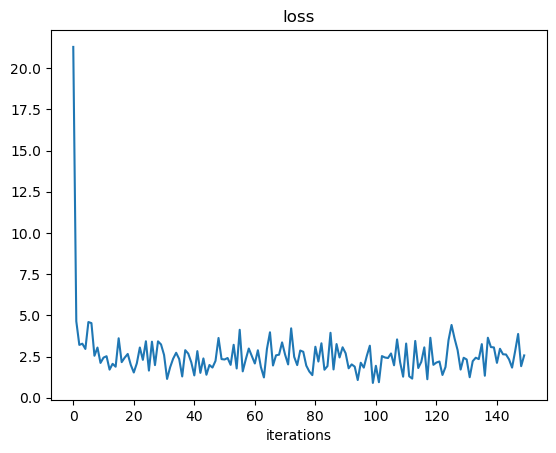

In [11]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
#plt.ylim(0,1000)
plt.show()

### Test

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
#from neural_soga import *

In [19]:
ncomp = 1
xdim = 2
nsamples = 1000

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
model = torch.load('params/truncNNdim2-1to1-cholesky.pth')

C:\Users\birik\AppData\Local\Temp\ipykernel_16920\3529814859.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim2-1to1-cholesky.pth')


In [20]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 10)
test_covariances = torch.empty(ncomp, xdim, xdim)

for j in range(ncomp):
  test_covariances[j] = generate_random_covariance(xdim, -5, 5)

test_samples = gm_sampling(test_weights, test_means, test_covariances, nsamples)

pi_pred, mu_pred, sigma_pred = model(test_samples)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, torch.linalg.inv(torch.mm(sigma_pred[0].t(), sigma_pred[0])))

Test params: tensor([1.]) tensor([[0.3447, 5.9277]]) tensor([[[ 6.6291,  9.2056],
         [ 9.2056, 12.8678]]])
Pred params: tensor([1.], grad_fn=<DivBackward0>) tensor([[2.2544, 7.9857]], grad_fn=<ExpBackward0>) tensor([[ 3.8005, -0.8667],
        [-0.8667,  3.7418]], grad_fn=<LinalgInvExBackward0>)


Consistently overestimates the covariance and the mean estimate is not accurate

In [21]:
import libSOGA

soga_dist = libSOGA.Dist(['x','y'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[0])], [np.array(test_covariances[0])]))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})
_, new_soga_dist = libSOGA.truncate(new_soga_dist, 'y>0', {})

soga_w = new_soga_dist.gm.pi[0]
soga_mean = new_soga_dist.gm.mu[0]
soga_cov = new_soga_dist.gm.sigma[0]

soga_w, soga_mean, soga_cov

(1.0,
 array([2.18529445, 8.4836386 ]),
 array([[2.60578774, 3.61847725],
        [3.61847725, 5.10907752]]))

pred weights =  [1.]
pred means =  [[2.2544158 7.9857497]]
pred covs =  tensor([[ 3.8005, -0.8667],
        [-0.8667,  3.7418]])


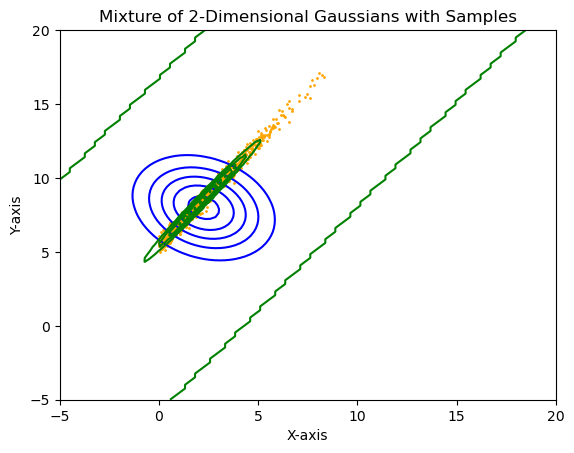

In [22]:
# Plotting
x, y = np.meshgrid(np.linspace(-5, 20, 100), np.linspace(-5, 20, 100))
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2 * np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos - mu, Sigma_inv, pos - mu)
    return np.exp(-fac / 2) / N

fig, ax = plt.subplots()

# Plot the contour of each Gaussian component
#for i in range(len(test_weights)):
#    z_in = multivariate_gaussian(pos, test_means[i].numpy(), covariances[i].numpy())
#    ax.contour(x, y, z_in, levels=5, colors='orange')

print('pred weights = ', pi_pred.detach().numpy())
print('pred means = ', mu_pred.detach().numpy())
sigma_pred = sigma_pred.detach()[0]
cov_pred = torch.linalg.inv(torch.mm(sigma_pred.t(), sigma_pred))
print('pred covs = ', cov_pred)
cc = ['b', 'g']
for i in range(len(pi_pred)):
    z_out = multivariate_gaussian(pos, mu_pred[i].detach().numpy(), cov_pred)
    CS_pred = ax.contour(x, y, z_out, levels=5, colors='blue')  # predicted
handles_pred, labels_pred = CS_pred.legend_elements('NN');
#plt.legend(handles_pred, labels_pred, loc='upper right')
    
# for i in range(len(test_weights)):
    # z_out = multivariate_gaussian(pos, test_means[i].detach().numpy(), test_covariances[i].detach().numpy())
    # ax.contour(x, y, z_out, levels=5, colors='orange')   # original
    
z_out = multivariate_gaussian(pos,soga_mean, soga_cov)
CS_soga = ax.contour(x, y, z_out, levels=5, colors='green')   # SOGA
handles_soga, labels_soga = CS_soga.legend_elements('SOGA');
#plt.legend(handles_pred + handles_soga, labels_pred+labels_soga)

# Plot the samples
ax.scatter(test_samples[:, 0], test_samples[:, 1], s=1, c='orange')
#plt.legend()
plt.title('Mixture of 2-Dimensional Gaussians with Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.savefig('dim2-1to1-truncation.png')

plt.show()

# Da qui in poi non eseguire

# Truncation 1 to 1

## Dimension 1 

### Training

In [8]:
nsamples = 500
niter = 100000

ncomp = 1
xdim = 1

bounds_mu = [0*torch.ones(xdim),100*torch.ones(xdim)]
bounds_sigma = [-10*torch.ones(xdim**2), 10*torch.ones(xdim**2)]


In [9]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(0, 2)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
      covariances[j] = generate_random_covariance(xdim, -1, 1)

    samples = gm_sampling(weights, means, covariances, nsamples)

    pi_new, mu_new, sigma_new = model(samples)

    loss = loss_function(samples, pi_new, mu_new, sigma_new)


    # Backpropagation
    loss.backward()
    optimizer.step()


    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {t/niter*100}%")

print("Done!")

loss: 7.743793 0.0%
loss: 0.901091 1.0%
loss: 1.074973 2.0%
loss: 1.197235 3.0%
loss: 0.625462 4.0%
loss: 1.060450 5.0%
loss: 0.908363 6.0%
loss: 1.121251 7.000000000000001%
loss: 1.258591 8.0%
loss: 0.439639 9.0%
loss: 0.975374 10.0%
loss: 1.222692 11.0%
loss: 0.584660 12.0%
loss: 1.417349 13.0%
loss: 1.518550 14.000000000000002%
loss: 0.933830 15.0%
loss: 1.367322 16.0%
loss: 1.110824 17.0%
loss: 1.318564 18.0%
loss: 0.809869 19.0%
loss: 0.568222 20.0%
loss: 1.246939 21.0%
loss: 1.370966 22.0%
loss: 1.418361 23.0%
loss: 1.143203 24.0%
loss: 1.387892 25.0%
loss: 0.830561 26.0%
loss: 1.181834 27.0%
loss: 1.278598 28.000000000000004%
loss: 0.593901 28.999999999999996%
loss: 1.188691 30.0%
loss: 1.243723 31.0%
loss: 0.510650 32.0%
loss: 1.232209 33.0%
loss: 0.821736 34.0%
loss: 1.216925 35.0%
loss: 1.586242 36.0%
loss: 1.503320 37.0%
loss: 0.409892 38.0%
loss: 1.195214 39.0%
loss: 0.969329 40.0%
loss: 1.182968 41.0%
loss: 1.346014 42.0%
loss: 1.036156 43.0%
loss: 1.072481 44.0%
loss: 1.4

In [24]:
torch.save(model, 'params/truncNNdim1-1to1.pth')

In [25]:
import matplotlib.pyplot as plt
import numpy as np

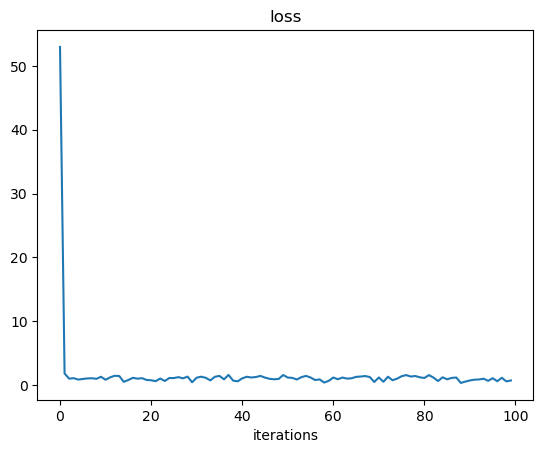

In [26]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
plt.show()

### Test

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from neural_soga import *

In [2]:
ncomp = 1
xdim = 1
nsamples = 500

model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples)
model = torch.load('params/truncNNdim1-1to1.pth')



C:\Users\birik\AppData\Local\Temp\ipykernel_10920\2284748912.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('params/truncNNdim1-1to1.pth')


In [3]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 50)
test_covariances = torch.empty(ncomp, xdim, xdim)

for j in range(ncomp):
  test_covariances[j] = generate_random_covariance(xdim, -5, 5)

test_samples = gm_sampling(test_weights, test_means, test_covariances, 500)

pi_pred, mu_pred, sigma_pred = model(test_samples)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: tensor([1.]) tensor([[4.1265]]) tensor([[[12.3602]]])
Pred params: tensor([1.], grad_fn=<DivBackward0>) tensor([[4.4295]], grad_fn=<ReluBackward0>) tensor([[[99.9722]]], grad_fn=<CopySlices>)


In [4]:
import libSOGA

soga_dist = libSOGA.Dist(['x'], libSOGA.GaussianMix(np.array([1.]), [np.array(test_means[0])], [np.array(test_covariances[0])]))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

soga_w = new_soga_dist.gm.pi[0]
soga_mean = new_soga_dist.gm.mu[0]
soga_cov = new_soga_dist.gm.sigma[0]

soga_w, soga_mean, soga_cov

imported network


C:\Users\birik\github\SOGA4SSA\src\libSOGAssa.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trunc_NN1 = torch.load('params/truncNNdim2-1to1.pth')


(1.0, array([4.92711381]), array([[8.4156375]]))

pred weights =  [1.]
pred means =  [[4.42954]]
pred covs =  [[[99.9722]]]


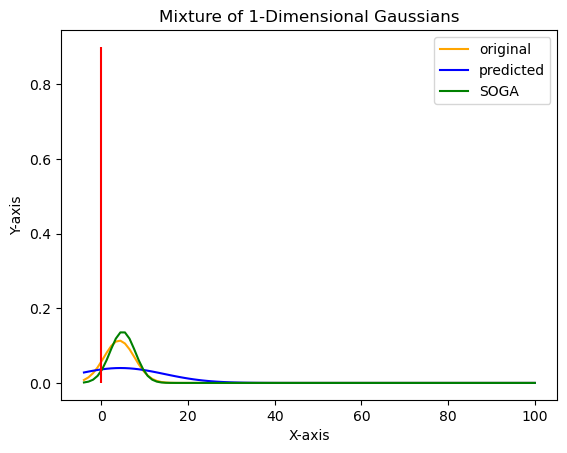

In [6]:
# Plotting
x = np.linspace(-4,100,100)

fig, ax = plt.subplots()

# Plot the contour of each Gaussian component
#for i in range(len(test_weights)):
#    z_in = multivariate_gaussian(pos, test_means[i].numpy(), covariances[i].numpy())
#    ax.contour(x, y, z_in, levels=5, colors='orange')

print('pred weights = ', pi_pred.detach().numpy())
print('pred means = ', mu_pred.detach().numpy())
print('pred covs = ', sigma_pred.detach().numpy())
cc = ['b', 'g']

from scipy.stats import norm

y_orig = norm.pdf(x, loc=test_means[0].detach().numpy(), scale=np.sqrt(test_covariances[0][0].detach().numpy()))
plt.plot(x, y_orig, color='orange', label='original')

y_pred = norm.pdf(x, loc=mu_pred[0].detach().numpy(), scale=np.sqrt(sigma_pred[0].detach().numpy()))[0]
plt.plot(x, y_pred, color='blue', label='predicted')

y_soga = norm.pdf(x, loc=soga_mean[0], scale=np.sqrt(soga_cov[0]))
plt.plot(x, y_soga, color='green', label='SOGA')

plt.vlines(x = 0, ymin=0, ymax=0.9, color='red')

plt.legend()
plt.title('Mixture of 1-Dimensional Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Train Truncation 2 to 2

## Dimension 2

### Training

In [8]:
nsamples = 500

niter = 100000

ncomp = 2
xdim = 2

bounds_mu = [0, 10]
bounds_sigma = [-10, 10]


In [9]:
model = ApproxTruncation(xdim=xdim, num_component_input=ncomp, num_component_output=ncomp, nsamples=nsamples, mean_ub= 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

model.train()

losses = []
for t in range(niter):

    optimizer.zero_grad()
    weights = torch.rand(ncomp)
    weights = weights / weights.sum()  # Normalize to sum to 1
    means = torch.empty(ncomp, xdim).uniform_(0, 2)
    covariances = torch.empty(ncomp, xdim, xdim)
    for j in range(ncomp):
      covariances[j] = generate_random_covariance(xdim, -1, 1)

    samples = gm_sampling(weights, means, covariances, nsamples)

    pi_new, mu_new, sigma_new = model(samples)

    loss = loss_function(samples, pi_new, mu_new, sigma_new)


    # Backpropagation
    loss.backward()
    optimizer.step()


    if t % 1000 == 0:
      tloss = loss.item() #batch * batch_size + len(X)
      losses.append(tloss)
      print(f"loss: {tloss:>7f} {t/niter*100}%")

print("Done!")

loss: 331.743469 0.0%
loss: 3.054123 1.0%
loss: 2.574522 2.0%
loss: 2.837376 3.0%
loss: 2.398493 4.0%
loss: 2.630446 5.0%
loss: 2.574900 6.0%
loss: 2.697211 7.000000000000001%
loss: 2.528661 8.0%
loss: 2.145931 9.0%
loss: 2.736506 10.0%
loss: 2.502836 11.0%
loss: 2.539833 12.0%
loss: 2.684067 13.0%
loss: 2.607018 14.000000000000002%
loss: 2.664315 15.0%
loss: 2.877844 16.0%
loss: 3.037752 17.0%
loss: 2.580238 18.0%
loss: 2.849550 19.0%
loss: 2.741462 20.0%
loss: 2.875848 21.0%
loss: 2.464997 22.0%
loss: 2.717878 23.0%
loss: 2.138066 24.0%
loss: 2.021704 25.0%
loss: 2.223405 26.0%
loss: 2.646730 27.0%
loss: 2.164281 28.000000000000004%
loss: 1.996130 28.999999999999996%
loss: 2.574481 30.0%
loss: 2.413094 31.0%
loss: 1.879542 32.0%
loss: 2.204200 33.0%
loss: 2.043259 34.0%
loss: 2.377090 35.0%
loss: 2.708835 36.0%
loss: 2.370599 37.0%
loss: 2.673440 38.0%
loss: 2.431185 39.0%
loss: 1.853119 40.0%
loss: 2.460469 41.0%
loss: 2.703721 42.0%
loss: 2.191004 43.0%
loss: 2.700709 44.0%
loss: 2

In [10]:
torch.save(model, 'truncNNdim2-2to2.pth')

In [11]:
import matplotlib.pyplot as plt
import numpy as np

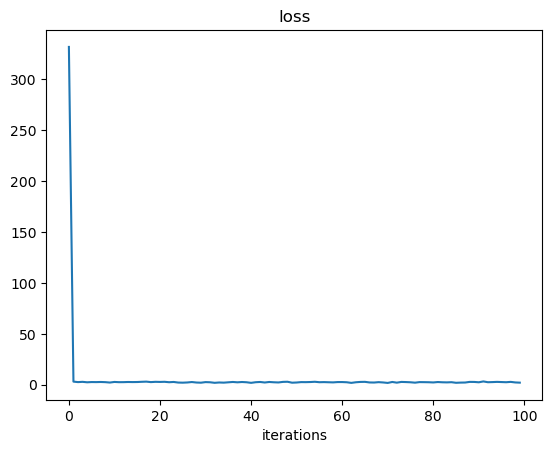

In [12]:
fig = plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.title('loss')
plt.xlabel('iterations')
plt.show()

### Test

In [12]:
import matplotlib.pyplot as plt
import numpy as np

#import torch
#from torch import nn
#from neural_soga import *

In [13]:
model = ApproxTruncation(2)
model = torch.load('truncNNdim2-2to2.pth')

ncomp = 2
xdim = 2

C:\Users\birik\AppData\Local\Temp\ipykernel_10196\2046160562.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('truncNNdim2-2to2.pth')


In [14]:
test_weights = torch.rand(ncomp)
test_weights = test_weights / test_weights.sum()  # Normalize to sum to 1
test_means = torch.empty(ncomp, xdim).uniform_(0, 2)
test_covariances = torch.empty(ncomp, xdim, xdim)

for j in range(ncomp):
  test_covariances[j] = generate_random_covariance(xdim, -1, 1)

test_samples = gm_sampling(test_weights, test_means, test_covariances, 500)

pi_pred, mu_pred, sigma_pred = model(test_samples)

print('Test params:', test_weights, test_means, test_covariances)
print('Pred params:', pi_pred, mu_pred, sigma_pred)

Test params: tensor([0.0372, 0.9628]) tensor([[0.0242, 0.7371],
        [0.2463, 0.9299]]) tensor([[[1.1992, 0.2920],
         [0.2920, 0.7325]],

        [[1.5929, 0.5653],
         [0.5653, 1.1999]]])
Pred params: tensor([0.4976, 0.5024], grad_fn=<DivBackward0>) tensor([[0.5684, 1.2342],
        [1.6101, 1.3515]], grad_fn=<MulBackward0>) tensor([[[0.1287, 0.0370],
         [0.0370, 1.1023]],

        [[0.4584, 0.0834],
         [0.0834, 1.2448]]], grad_fn=<CopySlices>)


In [15]:
import libSOGA

soga_dist = libSOGA.Dist(['x','y'], libSOGA.GaussianMix(np.array(test_weights), np.array(test_means), np.array(test_covariances)))
_, new_soga_dist = libSOGA.truncate(soga_dist, 'x>0', {})

soga_w = new_soga_dist.gm.pi
soga_mean = new_soga_dist.gm.mu
soga_cov = new_soga_dist.gm.sigma

soga_w, soga_mean, soga_cov

([0.03294709192722143, 0.9670529080727784],
 [array([0.88261645, 0.94615463]), array([1.10190715, 1.23359836])],
 [array([[0.44158887, 0.10752876],
         [0.10752876, 0.68761697]]),
  array([[0.65003526, 0.23068496],
         [0.23068496, 1.08110972]])])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pred weights =  [0.49760675 0.5023932 ]
pred means =  [[0.5683624 1.2342285]
 [1.6100849 1.3514749]]
pred covs =  [[[0.12869148 0.03695422]
  [0.03695422 1.1023437 ]]

 [[0.45838362 0.08338016]
  [0.08338016 1.2448279 ]]]


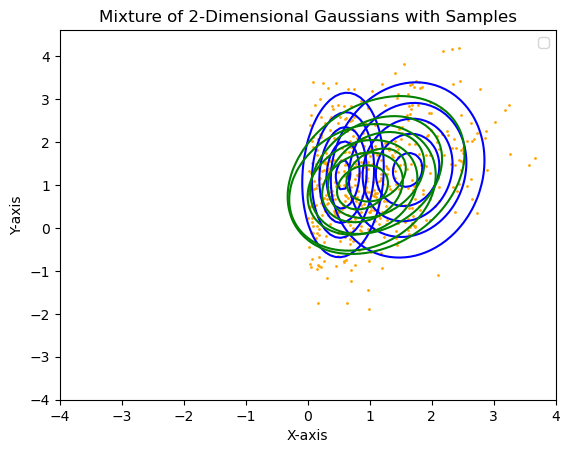

In [21]:
# Plotting
XX = 4
x, y = np.meshgrid(np.linspace(-XX, XX, 100), np.linspace(-XX, XX, 100))
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

def multivariate_gaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2 * np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos - mu, Sigma_inv, pos - mu)
    return np.exp(-fac / 2) / N

fig, ax = plt.subplots()

# Plot the contour of each Gaussian component
#for i in range(len(test_weights)):
#    z_in = multivariate_gaussian(pos, test_means[i].numpy(), covariances[i].numpy())
#    ax.contour(x, y, z_in, levels=5, colors='orange')

print('pred weights = ', pi_pred.detach().numpy())
print('pred means = ', mu_pred.detach().numpy())
print('pred covs = ', sigma_pred.detach().numpy())
cc = ['b', 'g']

for i in range(len(pi_pred)):
    z_out = pi_pred[i].detach().numpy()*multivariate_gaussian(pos, mu_pred[i].detach().numpy(), sigma_pred[i].detach().numpy())
    ax.contour(x, y, z_out, levels=5, colors='blue')  # predicted

# for i in range(len(test_weights)):
    # z_out = multivariate_gaussian(pos, test_means[i].detach().numpy(), test_covariances[i].detach().numpy())
    # ax.contour(x, y, z_out, levels=5, colors='orange')   # original

for i in range(len(soga_w)):
    z_out = soga_w[i]*multivariate_gaussian(pos, soga_mean[i], soga_cov[i])
    ax.contour(x, y, z_out, levels=5, colors='green')   # SOGA


# Plot the samples
ax.scatter(test_samples[:, 0], test_samples[:, 1], s=1, c='orange')
plt.legend()
plt.title('Mixture of 2-Dimensional Gaussians with Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()